<a href="https://colab.research.google.com/github/LucasHLirio/TCC_II/blob/main/CNN_BO_MNIST_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Install and import the Keras Tuner:

In [ ]:
import tensorflow as tf
from tensorflow import keras

!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 27.2 MB/s eta 0:00:00
Using TensorFlow backend


Test the GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Download and prepare the dataset



In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.mnist.load_data(path="mnist.npz")

#Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

11490434/11490434 [==============================] - 0s 0us/step


##Build the model

In [ ]:
def model_builder(hp):
  # Defining the scope of the Hyperparameters:----------------------------------

  # convolutional layers
  hp_conv1_units = hp.Int('conv1_units', min_value=32, max_value=512, step=32)
  hp_conv2_units = hp.Int('conv2_units', min_value=32, max_value=512, step=32)
  hp_conv3_units = hp.Int('conv3_units', min_value=32, max_value=512, step=32)

  hp_kernel_size1 =  hp.Int('kern_size1', min_value=3, max_value=5)
  hp_kernel_size2 =  hp.Int('kern_size2', min_value=3, max_value=5)
  hp_kernel_size3 =  hp.Int('kern_size3', min_value=3, max_value=5)

  hp_pool_size1 = hp.Int('pool_sz1', min_value=2, max_value=4)
  hp_pool_size2 = hp.Int('pool_sz2', min_value=2, max_value=4)
  hp_pool_size3 = hp.Int('pool_sz3', min_value=2, max_value=4)

  hp_stride_conv1 = hp.Int('stride_conv1', min_value=1, max_value=5)
  hp_stride_conv2 = hp.Int('stride_conv2', min_value=1, max_value=5)
  hp_stride_conv3 = hp.Int('stride_conv3', min_value=1, max_value=5)

  hp_stride_pool1 = hp.Int('stride_pool1', min_value=1, max_value=5)
  hp_stride_pool2 = hp.Int('stride_pool2', min_value=1, max_value=5)
  hp_stride_pool3 = hp.Int('stride_pool3', min_value=1, max_value=5)

  # dense layers
  hp_activation=hp.Choice('activation', values=['relu','tanh','sigmoid'])

  hp_dense_units1 = hp.Int('dense_units1', min_value=32, max_value=512, step=32)
  hp_dense_units2 = hp.Int('dense_units2', min_value=32, max_value=512, step=32)

  hp_dropout_rate1 = hp.Choice('dropout_rate1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_dropout_rate2 = hp.Choice('dropout_rate2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

  #defining the optimizer and it's learning rate
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3])
  optimizer = tf.keras.optimizers.get(hp_optimizer)
  optimizer.learning_rate = hp_learning_rate


  #Building the model:----------------------------------------------------------

  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(28, 28, 1))),

  model.add(keras.layers.Conv2D(hp_conv1_units, kernel_size=(hp_kernel_size1), strides=(hp_stride_conv1), padding='same')), # conv1
  model.add(keras.layers.MaxPooling2D(pool_size=(hp_pool_size1), strides=(hp_stride_pool1), padding='same')), # max pool 1
  model.add(keras.layers.Conv2D(hp_conv2_units, kernel_size=(hp_kernel_size2), strides=(hp_stride_conv2), padding='same')), # conv2
  model.add(keras.layers.MaxPooling2D(pool_size=(hp_pool_size2), strides=(hp_stride_pool2), padding='same')), # max pool 2
  model.add(keras.layers.Conv2D(hp_conv3_units, kernel_size=(hp_kernel_size3), strides=(hp_stride_conv3), padding='same')), # conv3
  model.add(keras.layers.MaxPooling2D(pool_size=(hp_pool_size3), strides=(hp_stride_pool3), padding='same')), # max pool 3

  model.add(keras.layers.Flatten()) # flatten

  model.add(keras.layers.Dense(units=hp_dense_units1, activation=hp_activation)) # dense 1
  model.add(keras.layers.Dropout(hp_dropout_rate1)), # dropout 1

  model.add(keras.layers.Dense(units=hp_dense_units2, activation=hp_activation)) # dense 2
  model.add(keras.layers.Dropout(hp_dropout_rate2)), # dropout 2

  model.add(keras.layers.Dense(10)) # dense output

  model.compile(optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hypertuning
In this case we use the Bayesian Optimization method

In [ ]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    num_initial_points=50,
    max_trials=15,
    directory='my_dir',
    project_name='cnn_bayes')

Create a callback to stop training early after reaching a certain value for the validation loss.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run the hyperparameter search

In [ ]:
import time
start = time.time() # will measure the searching duration

tuner.search(img_train, label_train, epochs=50, validation_split=0.4, callbacks=[stop_early]) # run the HP search

Trial 15 Complete [00h 01m 46s]
val_accuracy: 0.7106666564941406

Best val_accuracy So Far: 0.9915000200271606
Total elapsed time: 00h 46m 41s


In [ ]:
end = time.time()
search_duration = end-start
search_minutes = search_duration/60

print(f'Search duration: {search_duration:.3f} seconds ({search_minutes:.2f} minutes)')

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("-----------------THE BEST HPs ARE:-----------------\n")
best_hps.values

Search duration: 2800.572 seconds (46.68 minutes)
-----------------THE BEST HPs ARE:-----------------



{'conv1_units': 352,
 'conv2_units': 352,
 'conv3_units': 192,
 'kern_size1': 5,
 'kern_size2': 5,
 'kern_size3': 4,
 'pool_sz1': 2,
 'pool_sz2': 4,
 'pool_sz3': 3,
 'stride_conv1': 3,
 'stride_conv2': 1,
 'stride_conv3': 1,
 'stride_pool1': 1,
 'stride_pool2': 2,
 'stride_pool3': 4,
 'activation': 'tanh',
 'dense_units1': 64,
 'dense_units2': 288,
 'dropout_rate1': 0.1,
 'dropout_rate2': 0.0,
 'optimizer': 'SGD',
 'learning_rate': 0.1}

## Train the model

In [ ]:
# Build the model with the optimal HPs and train it

hypermodel = tuner.hypermodel.build(best_hps)

fit_start = time.time()
history = hypermodel.fit(img_train, label_train, epochs=100, validation_split=0.4)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'\nBest epoch:{best_epoch}')

Epoch 1/100
1125/1125 [==============================] - 23s 20ms/step - loss: 0.2587 - accuracy: 0.9131 - val_loss: 0.0604 - val_accuracy: 0.9812
Epoch 2/100
1125/1125 [==============================] - 24s 21ms/step - loss: 0.0498 - accuracy: 0.9856 - val_loss: 0.0462 - val_accuracy: 0.9858
Epoch 3/100
1125/1125 [==============================] - 23s 21ms/step - loss: 0.0280 - accuracy: 0.9913 - val_loss: 0.0468 - val_accuracy: 0.9854
Epoch 4/100
1125/1125 [==============================] - 22s 20ms/step - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0.0457 - val_accuracy: 0.9866
Epoch 5/100
1125/1125 [==============================] - 22s 20ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0375 - val_accuracy: 0.9892
Epoch 6/100
1125/1125 [==============================] - 23s 21ms/step - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.0468 - val_accuracy: 0.9865
Epoch 7/100
1125/1125 [==============================] - 22s 20ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0

In [ ]:
fit_end = time.time()
fit_duration = fit_end-fit_start
fit_minutes = fit_duration/60

print(f'Training duration: {fit_duration:.3f} seconds ({fit_minutes:.2f} minutes)')

Training duration: 2302.757 seconds (38.38 minutes)


##Evaluate the Hypermodel

In [ ]:
eval_result = hypermodel.evaluate(img_test, label_test)
print(f'\n\nTest loss: {100*eval_result[0]:.2f} %\nTest accuracy: {100*eval_result[1]:.2f} %')

313/313 [==============================] - 3s 7ms/step - loss: 0.0271 - accuracy: 0.9934


Test loss: 2.71 %
Test accuracy: 99.34 %


In [ ]:
print("------------ BEST HYPERPARAMETERS FOUND ------------\n")
best_hps.values

------------ BEST HYPERPARAMETERS FOUND ------------



{'conv1_units': 352,
 'conv2_units': 352,
 'conv3_units': 192,
 'kern_size1': 5,
 'kern_size2': 5,
 'kern_size3': 4,
 'pool_sz1': 2,
 'pool_sz2': 4,
 'pool_sz3': 3,
 'stride_conv1': 3,
 'stride_conv2': 1,
 'stride_conv3': 1,
 'stride_pool1': 1,
 'stride_pool2': 2,
 'stride_pool3': 4,
 'activation': 'tanh',
 'dense_units1': 64,
 'dense_units2': 288,
 'dropout_rate1': 0.1,
 'dropout_rate2': 0.0,
 'optimizer': 'SGD',
 'learning_rate': 0.1}

In [ ]:
hypermodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 10, 352)       9152      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 352)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 352)       3097952   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 352)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 192)         1081536   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 192)        

###Plot loss and accuracy curves

Text(0.5, 1.0, 'Loss Curves')

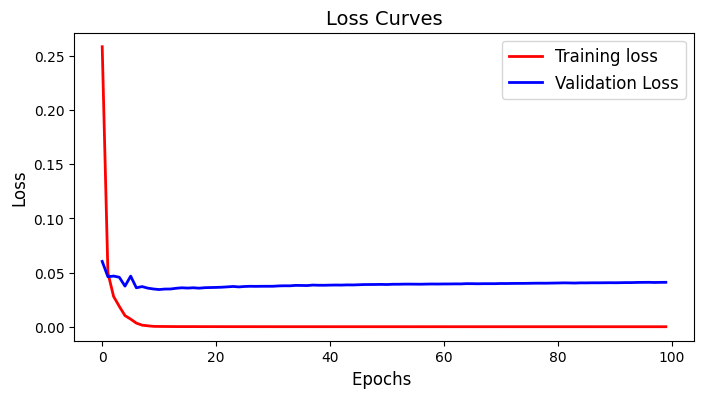

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[8,4])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=14)

Text(0.5, 1.0, 'Accuracy Curves')

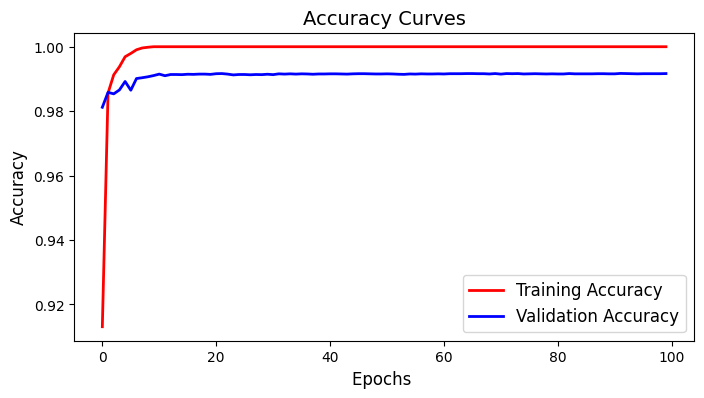

In [ ]:
plt.figure(figsize=[8,4])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves',fontsize=14)

In [ ]:
# HPS:
# 'conv_units'
# 'dense_units'
# 'kernel_size'
# 'pool_size'
# 'strides'
# 'activation function'
# 'dropout_rate'
# 'optimizer'
# 'learning_rate'